In [1]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./use_4.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
label=train_data['丙烯选择性']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def ETR_cv(n_estimators, min_samples_split, max_depth):
    val = cross_val_score(
        ExtraTreesRegressor(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            random_state=1314
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [5]:
ETR_opt = BayesianOptimization(
        ETR_cv,
        {'n_estimators': (50, 1000),
        'min_samples_split': (2, 25),
        'max_depth': (2, 15)}
    )

In [40]:
ETR_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.693     | 10.03     | 8.934     | 313.3     |
| 2         | 0.3756    | 3.582     | 17.76     | 870.0     |
| 3         | 0.5991    | 5.215     | 4.32      | 345.6     |
| 4         | 0.6989    | 9.766     | 3.033     | 509.9     |
| 5         | 0.6259    | 9.116     | 23.85     | 317.8     |
| 6         | 0.6725    | 8.653     | 9.259     | 312.8     |
| 7         | 0.7068    | 14.82     | 6.378     | 325.9     |
| 8         | 0.5621    | 5.952     | 21.32     | 523.9     |
| 9         | 0.6968    | 10.8      | 2.08      | 490.8     |
| 10        | 0.6281    | 13.04     | 23.82     | 485.9     |
| 11        | 0.6052    | 5.762     | 2.035     | 464.8     |
| 12        | 0.2456    | 2.0       | 10.44     | 499.1     |
| 13        | 0.6705    | 13.14     | 13.6      | 321.1     |
| 14        | 0.6984    | 9.76      | 3.334     | 320.0     |
| 15    

In [6]:
model = ExtraTreesRegressor(n_estimators=1000,
                            max_samples=145,
                            bootstrap=True,
                            random_state=1314).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.7057986592065921
rmse: 11.485647227376466


In [7]:
test_x = test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1)
test_y = test_data['丙烯选择性']
test_score = model.score(test_x,test_y)
print('测试集得分为：', test_score)

测试集得分为： 0.5981580058435946


In [8]:
# 预测1
Y1=model.predict(X=test_data.drop(['丙烯选择性','Unnamed: 0'],axis=1))
Y2=test_data['丙烯选择性']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [9]:
# 预测2
Y_1=model.predict(X=feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

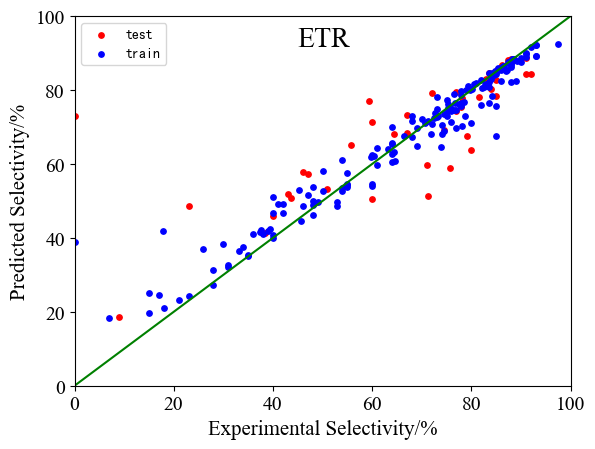

In [15]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(45,92,'ETR',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()

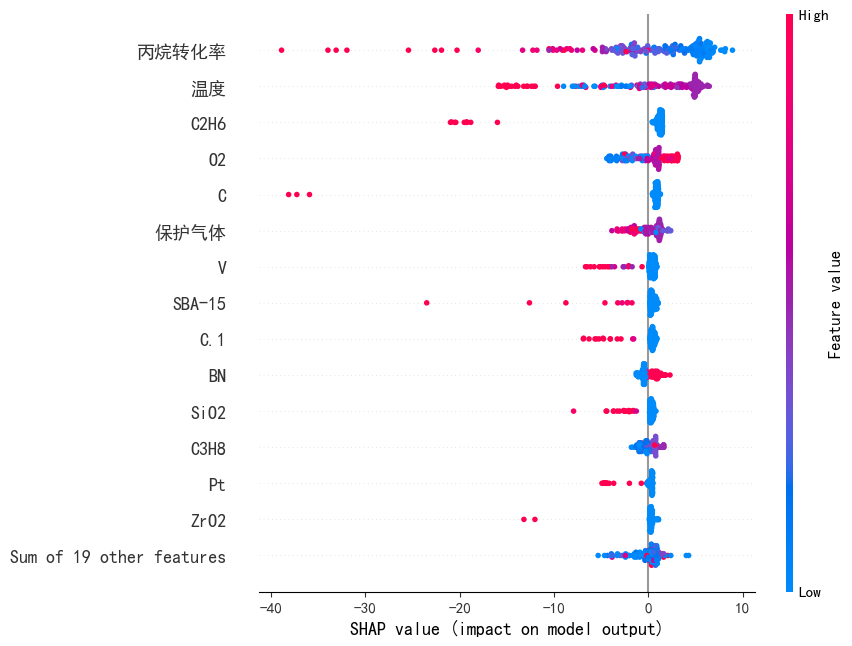

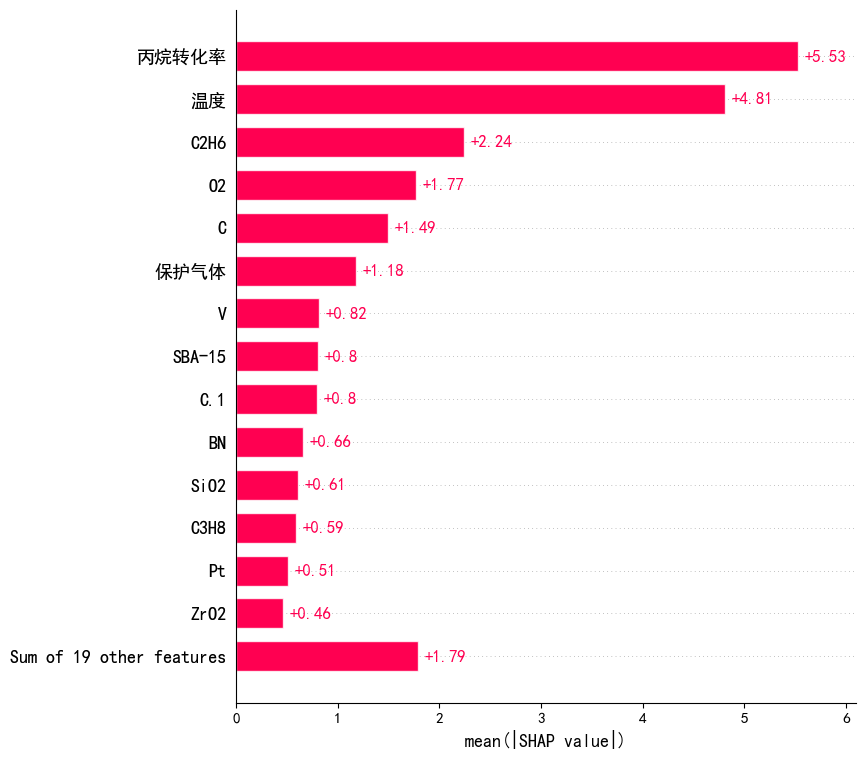

In [17]:
# shap提高解释性
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=15)
shap.plots.bar(shap_values, max_display=15)